# Two-branched DNN Car Reservation Prediction 

# Overview
Our goal is to predict the number of reservations of vehicles (number of unique reservations per vehicle (non-negative numeric) and reservation type (categorical)) using six input features. The two output variables makes this a multi-output problem. We have several options to build a multi-output deep neural network: (1) Create an output layer using sigmoid with a single loss "MSE" for the categorical and the scaled numeric variable (between -1 and 1), or even better (2) create a 2-branched DNN with an independent sigmoid output layer for the categorical output with cross-entropy loss, and a ReLU linear regression output layer for the non-negative numeric variable with MSE loss.

Benchmark ML approaches using a multi-feature linear regression model and SVM (for numeric output), and a logistic regression (for categorical output) will be developed to compare with the 2-branched DNN.

# Background

My math notebooks ([support vector machine](https://github.com/ginochen/ML_notes/blob/master/support_vector_machine.ipynb), [logistic regression](https://github.com/ginochen/ML_notes/blob/master/logistic_regression_cross_entropy.ipynb), [stochastic gradient descent](https://github.com/ginochen/ML_notes/blob/master/stochastic_gradient_descent.ipynb)) for the ML tools used in this project serve as reminders of what's really happening algorithmically in the python packages.



# Data 
Due to confidentiality issues of the data, let's import, clean and PCA transform the feature space. The PCA also serve as a normalizer which makes training converge faster for SVM.

In [133]:
# as before load all lib here
import pandas as pd
import numpy as np
import math
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.decomposition import PCA
from sklearn.linear_model import LinearRegression, LogisticRegression # logistic regression function p(x) = 1/(1+e^{b^T*x}), logit(p) = b^T*x
from sklearn.metrics import precision_recall_fscore_support, mean_squared_error
from sklearn.metrics import classification_report
from sklearn.svm import SVC
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.model_selection import GridSearchCV
from sklearn import preprocessing

import tensorflow as tf
import keras
from keras.models import Sequential
from keras.layers import Input, Dense, Dropout, LSTM, TimeDistributed, Activation, LeakyReLU, BatchNormalization
from keras.callbacks import EarlyStopping, ModelCheckpoint

from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt


In [ ]:
import numpy as np
class measures():
    def __init__(self,y):
        self.y = y
    def mad(self): # median_absolute_deviation, measures the variability of a 1-D data
        return np.median(np.absolute(self.y - np.median(self.y))) # MAD
    @staticmethod
    def mse(y,z): # no need to load sklearn, just use this like a regular function, data_measures.mean_squared_error(np.array([3,5,7]),np.array([1,3,4]))
        return np.mean((y - z)**2) # mean_squared_error
        

In [ ]:
prediction_samp=10000

In [2]:
df_vehicles = pd.read_csv('./vehicles.csv')
df_reservations = pd.read_csv('./reservations.csv')

In [3]:
#print('VEHICLES\n =============================================== \n',df_vehicles.head(4))
#print('\nRESERVATIONS\n ========================================== \n',df_reservations.head(4))

In [241]:
df = pd.merge(df_reservations,df_vehicles, how='inner', on='vehicle_id') # join on intersection on vehicle_id
tmp = df.groupby('vehicle_id').reservation_id.nunique().to_frame()
tmp.columns = ["n_reserve"] # rename the column to number of reservations for each unique vehicle ID
df = pd.merge(df,tmp,how='inner',on='vehicle_id')
#drop_duplicates() 
print(df.iloc[:5,:])

   vehicle_id  reservation_id  reservation_type  is_delivery  actual_price  \
0      238780       2677903.0               2.0            0           121   
1      238780       3187363.0               2.0            0           121   
2      309795       2752124.0               2.0            1            61   
3      309795       2731316.0               2.0            1            61   
4      309795       3119198.0               1.0            1            61   

   recommended_price  num_images  description_length  is_recent_model  \
0                 48           9                   0                0   
1                 48           9                   0                0   
2                 66          12                   0                0   
3                 66          12                   0                0   
4                 66          12                   0                0   

   n_reserve  
0          2  
1          2  
2         11  
3         11  
4         11  


In [5]:
print('(samples, features) = %s'%str(df.shape))
print('max description length = %s'%str(df.description_length.max()))

(samples, features) = (195243, 10)
max description length = 7780


Let's checkout the feature space characteristics! Instead of using all 6 dim, which is hard to visualize, let's just look at the top 3 principle axes feature space:

x = 
is_delivery             0.0
actual_price          121.0
recommended_price      48.0
num_images              9.0
description_length      0.0
is_recent_model         0.0
Name: 0, dtype: float64

y_num: 
number of reservation = [ 2  2 11 ...  0  0  0] 

y_cat: 
reservation_type = {0.0, 1.0, 2.0}

y_catx: reservation_type binarized = [[0 0 1]
 [0 0 1]]


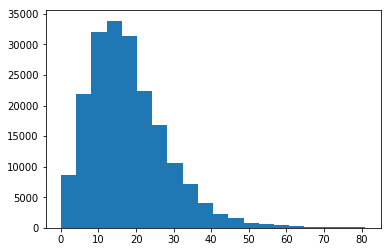

In [253]:
nrows = df.shape[0]
#df = df.dropna(axis=0) # drop NaNs
#x = df.iloc[:, [2,4,5,8]].values
x = df.iloc[:, range(3,9)].values # skip is_delivery since it's the tag
print('x = \n%s'%str(df.iloc[0,range(3,9)]))
y_num = df['n_reserve'].values # the tag to color mark on projected features
y_cat = df['reservation_type'].values
y_cat[np.isnan(y_cat_orig)]=0
lb = preprocessing.LabelBinarizer()
y_catx = lb.fit_transform(y_cat) # binarizer transformed y_cat into [nsamples,n_cats] matrix
print('\ny_num: \nnumber of reservation = %s \n\ny_cat: \nreservation_type = %s'%(str(y_num),str(set(y_cat))))
print('\ny_catx: reservation_type binarized = %s'%str(y_catx[:2,:]))
plt.hist(y_num,20)
plt.show()

Let's split the reservation number into two classes high (>15) and low (<=15), and get a first look at how similar the two classes are using cosine similarity function:

In [167]:
def average_cosine_similarity(x,y,nsamp):
    '''
    x:  feature matrix [n_samples, n_features]
    y:  class vector   [n_samples]
    nsamp: number of samples to compute cosine similarity
    '''
    x1 = x[y==1,:] # class 1 feature data
    x0 = x[y==0,:] # class 0 feature data
    if nsamp>x1.shape[0] | nsamp>x0.shape[0]:
        nsamp = min(x1.shape[0],x0.shape[0])
        print('Use the lesser samples  = %s'%str(nsamp))
    cs01 = cosine_similarity(x1[:nsamp,:],x0[:nsamp,:]) # computes cosine simlilarity between all pairwise samples in x1 and x0
    #ed01 = np.linalg.norm(x1[:nsamp,:]-x0[:nsamp,:])
    plt.hist(cs01.reshape(-1,1),100); plt.show()
    
    print('The average cosine similarity = %s'%str(np.mean(cs01.reshape(-1,1))))
    print('The median cosine similarity = %s'%str(np.median(cs01.reshape(-1,1))))

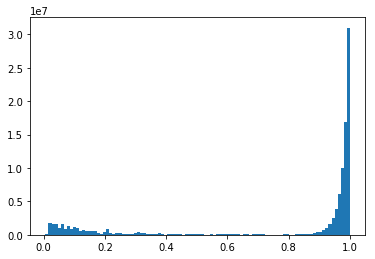

The average cosine similarity = 0.7817874561749854
The median cosine similarity = 0.9784254425331133


In [229]:
thres = 1
average_cosine_similarity(x,y_cat>thres,10000)
#np.linalg.norm(a-b) maybe do pairwise distance?

The average cosine similarity between the two classes are very high, meaning they are hard to separate in feature space.

Let's see if doing PCA transform can help separate the two sample classes:

In [224]:
pca = PCA(n_components=x.shape[1]) # use all 
pca.fit(x)

PCA(copy=True, iterated_power='auto', n_components=6, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False)

In [225]:
s = pca.singular_values_
print(s)  # just the eigenvalues of the PC direction vectors, also the stdev of the PCs

[2.36941876e+05 3.17776567e+04 8.00781480e+03 2.23030351e+03
 2.05296110e+02 1.88772658e+02]


In [226]:
print(pca.explained_variance_ratio_) # ([i/sum(pca.singular_values_**2) for i in pca.singular_values_**2])

[9.81143164e-01 1.76478773e-02 1.12066750e-03 8.69313996e-05
 7.36563472e-07 6.22768905e-07]


The sigular values are just the PC stdev of the PC axes, and the explained variance are just the component variances (i.e., squared stdev) divide by the total variance. 

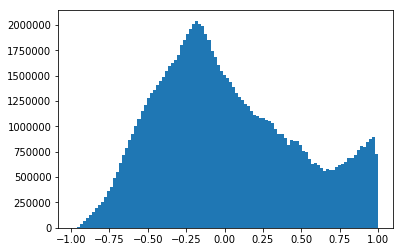

The average cosine similarity = 0.015084450410159206
The median cosine similarity = -0.06231304008082199


In [227]:
P = pca.transform(x) # the projection of all samples on all PC axes, 
PC_normal = np.asarray([P[:,i]/s[i] for i in range(len(s))]).T # normalized PC: PC divided by sigular values
# we can use P = PCA(n_components=2).transform(x)  if we just want the projections on the first 2 components, 
# this gives the same values as the full transformation, but just trancated 
average_cosine_similarity(PC_normal,y_cat>thres,10000) # computes cosine simlilarity between all pairwise samples in x1 and x0

The mean and median consine similarity are very low, which shows that the two classes in PCA feature space are probably more separated.

Let's see how the projection behaves on the three leading modes in a plot:

Samples: Class 0 (red) = 1355, Class 1 (blue) = 800, Class 2 (green) = 1468


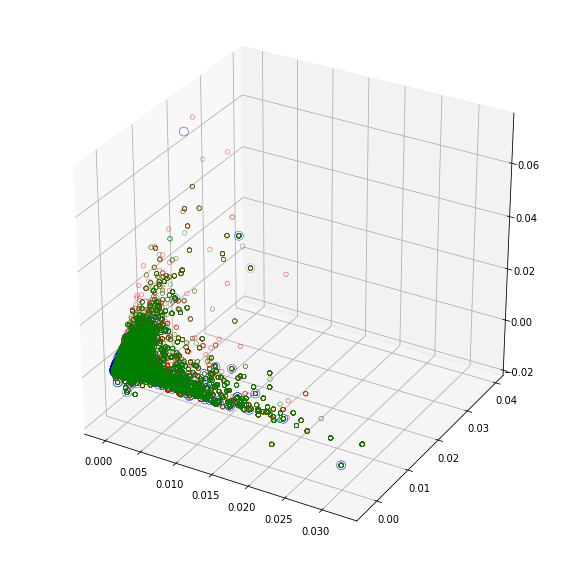

In [308]:
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111, projection='3d')
print("Samples: Class 0 (red) = %s, Class 1 (blue) = %s, Class 2 (green) = %s"%(sum(y_cat==0),sum(y==1),sum(y==2)))
ax.scatter(PC_normal[y_cat==0,0], PC_normal[y_cat==0,1], PC_normal[y_cat==0,2], edgecolors='b', s=80, facecolors='none', linewidths=0.5, label='Class 0')
ax.scatter(PC_normal[y_cat==1,0], PC_normal[y_cat==1,1], PC_normal[y_cat==1,2], edgecolors='r', s=20, facecolors='none', linewidths=0.5, label='Class 1')
ax.scatter(PC_normal[y_cat==2,0], PC_normal[y_cat==2,1], PC_normal[y_cat==2,2], edgecolors='g', s=20, facecolors='none', linewidths=0.5, label='Class 2')

plt.show()

Seems like the three classes are not well separated (except some outliers) in the PCA feature space. The result might be dissapointing, but nevertheless we still want to see if the highly nonlinear DNN with multi-output architecture captures the nonlinear decision boundary!

Since rescaling is recommended for reasons such as making feature space more "spherical" instead of "elliptical" to speed up the stochastic gradient descent. Therefore we will just work on the normalized PC to avoid using `sklearn.preprocessing` to rescale the data.

We are going to look at logistic regression, SVM and finally DNN.


Let's split the data into 80% training, 10% validation and 10% testing:

In [258]:
np.random.shuffle(PC_normal) # shuffle along the first axis to de-order the samples
#scaler = preprocessing.StandardScaler().fit(x) # standard normal z-scaling
#xz = scaler.transform(x) # z-scaling
#x_train,x_valid,x_test = x[:ntrain,:], x[ntrain:nvalid,:], x[nvalid:,:] # no scaling
#x_train,x_valid,x_test = xz[:ntrain,:], xz[ntrain:nvalid,:], xz[nvalid:,:] # z scaling
def split_train_valid_test(x,proportion=[0.8,0.9]):
    ntrain = round(proportion[0]*x.shape[0])
    nvalid = round(proportion[1]*x.shape[0])
    return x[:ntrain], x[ntrain:nvalid], x[nvalid:] 
x_train,x_valid,x_test             = split_train_valid_test(PC_normal,[0.8,0.9])
y_num_train,y_num_valid,y_num_test = split_train_valid_test(y_num,[0.8,0.9])
y_cat_train,y_cat_valid,y_cat_test = split_train_valid_test(y_catx,[0.8,0.9])
print(x_train.shape,x_valid.shape,x_test.shape,y_num_train.shape,y_cat_train.shape)

(156194, 6) (19525, 6) (19524, 6) (156194,) (156194, 3)


# Train Models

### Multi-linear Regression

In [143]:
reg = LinearRegression().fit(x_train,y_train)
reg.score(x_train,y_train)
y_pred_linreg = reg.predict(x_test[:prediction_samp])
print('Mean squared error = %s'%str(mean_squared_error(y_test[:prediction_samp],y_pred_linreg)))

Mean squared error = 106.87448226171418


### Logistict Regression
Let's start with logistic regression:

In [48]:
logreg = LogisticRegression(C=1e5, solver='lbfgs').fit(x_train,y_train) # multinomial uses cross entropy 
y_pred_lr = logreg.predict(x_test)
y_predp_lr = logreg.predict_proba(x_test)
print(classification_report(y_test,y_pred_lr,target_names=['class 0','class 1'])) # support is just the # of samples detected or used
# X = [n_samples, n_features], y = [n_samples]
# C = Inverse of regularization strength; must be a positive float. 
#     Like in support vector machines, smaller values specify stronger regularization.
# solver = 'sag': stochastic average gradient descent
#        = 'lbfgs': some Newton method
print('first two actual classes = %s'%str(y_test[:2]))
print('first two predicted classes = %s'%str(logreg.predict(x_test[:2,:]))) # predict class vs real class
print('first two predicted probalities [0 vs 1] = %s'%str(logreg.predict_proba(x_test[:2,:]))) # predict
# print('score = %s'%str(logreg.score(x_test,y_test))) # Score is the ratio of correctly predicted (TP+TN) samples.

first two actual classes = [1 1]
first two predicted classes = [1 1]
first two predicted probalities [0 vs 1] = [[0.26305848 0.73694152]
 [0.26305847 0.73694153]]
              precision    recall  f1-score   support

     class 0       0.00      0.00      0.00      5150
     class 1       0.73      1.00      0.85     14239

   micro avg       0.73      0.73      0.73     19389
   macro avg       0.37      0.50      0.42     19389
weighted avg       0.54      0.73      0.62     19389



/usr/local/lib/python3.5/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


### SVM
SVM with kernel computes the distance between every training points which is super expensive O($n_\text{features} \times n_\text{observations}^2$), so reduce the training samples to <100000, and don't do parameter grid search:

In [49]:
 clf = SVC(gamma='auto') # For non-linear classification use 
                        # gamma: Kernel coefficient for ‘rbf’, ‘poly’ and ‘sigmoid’. 
                        # Default is set to 'rbf' which is Radial Basis Function kernel
clf.fit(x_train[:50000,:], y_train[:50000])            
# let's do a grid search over the C and Gamma parameter space, 
# C (=1/\lambda) is a regularization scale , larger (smaller) C gives lower (higher) bias and higher (lower) variance
# Gamma (=1/\sigma) is a scale on kernel "width/variance", larger (smaller) Gamma gives lower (higher) bias and higher (lower) variance
# go to https://github.com/ginochen/ML_notes to learn more about these two parameters   
# The kernel trick is super expensive since it computes distance between each point!!
# see solution https://datascience.stackexchange.com/questions/989/svm-using-scikit-learn-runs-endlessly-and-never-completes-execution
#C_range = np.logspace(-2, 10, 3) # linear spaced between log10scale -2 to 10, and returns 10 based exponents of 10^-2, ...1
#gamma_range = np.logspace(-9, 3, 3) 
#param_grid = dict(gamma=gamma_range, C=C_range) 
#cv = StratifiedShuffleSplit(n_splits=5, test_size=0.2, random_state=42)
#grid = GridSearchCV(SVC(), param_grid=param_grid, cv=cv)
#grid.fit(x_train, y_train)

#print("The best parameters are %s with a score of %0.2f"
#      % (grid.best_params_, grid.best_score_))

SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

In [50]:
y_pred_svc = clf.predict(x_test)
print(x_test.shape,y_pred_svc.shape,sum(y_pred_svc))

(19389, 3) (19389,) 19389


In [51]:
print(classification_report(y_test,y_pred_svc,target_names=['class 0','class 1']))

              precision    recall  f1-score   support

     class 0       0.00      0.00      0.00      5150
     class 1       0.73      1.00      0.85     14239

   micro avg       0.73      0.73      0.73     19389
   macro avg       0.37      0.50      0.42     19389
weighted avg       0.54      0.73      0.62     19389



/usr/local/lib/python3.5/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


### Branched DNN

In [259]:
import tensorflow as tf
import keras
from keras.models import Sequential
from keras.optimizers import Adam
from keras.layers import Model, Input, Dense, Dropout, Activation, LeakyReLU, BatchNormalization
from keras.callbacks import EarlyStopping, ModelCheckpoint
from sklearn.preprocessing import LabelBinarizer

class KerasBatchGenerator(object):
    def __init__(self,x,y_num,y_cat,batchsize,ndim,nsteps,skip_steps):
        self.x=x
        self.y_num=y_num
        self.y_cat=y_cat
        self.batchsize=batchsize
        self.istart=0
        self.nsteps=nsteps
        self.skip_steps = skip_steps
        self.ndim = ndim
    def generate(self):
        x = np.zeros((self.nsteps, self.ndim))            
        y_num = np.zeros((self.nsteps, 1))
        y_cat = np.zeros((self.nsteps, 3))
        while True:
            for i in range(self.batchsize):
                x, y_num, y_cat = self.x[self.istart:self.istart+self.nsteps,:], \
                    self.y_num[self.istart:self.istart+self.nsteps], \
                    self.y_cat[self.istart:self.istart+self.nsteps,:]
                self.istart += self.skip_steps             
                yield x, {'num_output': y_num, 'cat_output': y_cat} # yield returns a set of x,y values for model.fit_generator to perform batch training
        

class branched_dnn(object):
    def __init__(self,fpath):                      
        self.file = fpath+'/best_model.h5'                          
    @staticmethod
    def build_model(fpath,ndim,nepochs=50,hdim=100,hlayers=20,dropoutrate=0.2,learning_rate=0.001):
        inputShape = (ndim,) # does not include the mini-batch/batchsize samples axis
        inputs = Input(shape=inputShape)
        numericBranch  = branched_dnn(fpath).build_branch_model(inputs, \
                         finalAct='relu',name='num_output',nout=1,nin=ndim,hdim=hdim, \
                         hlayers=hlayers,dropoutRate=dropoutRate)
        categoryBranch = branched_dnn(fpath).build_branch_model(inputs, \
                         finalAct='softmax',name='cat_output',nout=3,nin=ndim,hdim=hdim, \
                         hlayers=hlayers,dropoutRate=dropoutRate)
        model = Model(inputs=inputs, outputs=[numericBranch, categoryBranch],name="branchednet")
        losses = {"num_output": "mean_squared_error", "cat_output": "categorical_crossentropy"}
        lossWeights = {"num_output": 1.0, "cat_output": 1.0}
        opt = Adam(lr=learning_rate, decay=learning_rate/nepochs) # with learning rate decay
        model.compile(optimizer=opt, loss=losses, loss_weights = lossWeights, metrics=["accuracy"])
        # checkpointer = keras.callbacks.ModelCheckpoint(filepath=datapath + '/model-{epoch:02d}.hdf5', verbose=1)
        checkpointer = [EarlyStopping(monitor='val_loss', patience=20), # patience: wait for at least 5 epochs before early stopping
        ModelCheckpoint(filepath=branched_dnn(fpath).file, monitor='val_loss', save_best_only=True, verbose=1)]
        # model.summary()
        return model, checkpointer
    def build_branch_model(self,x,finalAct=None,name=None,nout=None,nin=None,hdim=100,hlayers=20,dropoutRate=20):
        '''
        finalAct: 'softmax','sigmoid' for categorical, 'linear' or 'relu' for numerical
        name: just name the branches as you wish, e.g., 'category_output', 'numeric_output'
        '''
        #model = Sequential()
        x = Dense(hdim, input_dim=nin, kernel_initializer='glorot_normal')(x)
        BatchNormalization()
        x = Activation('relu')(x)
        for _ in range(hlayers-1):
            x = Dropout(dropoutRate)(x)
            #model.add(Dense(hdim, kernel_initializer='glorot_normal', activation='relu')) 
            x = Dense(hdim, kernel_initializer='glorot_normal')(x) 
            BatchNormalization()
            x = Activation('relu')(x)
            #model.add(Dense(1,kernel_initializer='glorot_normal', activation='sigmoid')) # determine the probability of anomaly 
            #model.add(LeakyReLU(alpha=0.3)) # f(x) = 0.3*x, 0.3 is a small gradient
        x = Dense(nout,kernel_initializer='glorot_normal')(x) # determine the number
        BatchNormalization()
        x = Activation(finalAct,name=name)(x)
        return x
    
# Define model parameters
fpath = './'
batchsize = 100 # number of mini-batches per epoch
nsteps = 28 # number of samples in each mini-batch
ndim = x_train.shape[1]  # feature dimensions
hdim = 100 # hidden layer dimensions
hlayers= 20 # hidden layers
last_epoch = 0 # set to 0 for new model training
nepochs=10
dropoutRate = 0.5
learningRate=0.001
prediction_samp = 10000
ntrain = x_train.shape[0]
nvalid = x_valid.shape[0]

# initialize training and validation mini-batch data generator
train_gen = KerasBatchGenerator(x_train,y_num_train,y_cat_train, 
                          batchsize, ndim, nsteps, skip_steps=nsteps)
valid_gen = KerasBatchGenerator(x_valid,y_num_valid,y_cat_valid, 
                          batchsize, ndim, nsteps, skip_steps=nsteps)
#test_gen  = KerasBatchGenerator(np.concatenate((x_test,y_test.reshape(-1,1)),axis=1), 
#                          10, ndim, 1000, skip_steps=nsteps)
model, checkpointer  = branched_dnn(fpath).build_model(fpath,ndim,nepochs=nepochs,hdim=hdim,hlayers=hlayers,
                                   dropoutrate=dropoutRate,learning_rate=learningRate)
model.fit_generator(train_gen.generate(), ntrain//(batchsize*nsteps), epochs=last_epoch+nepochs,
                validation_data = valid_gen.generate(), validation_steps=math.ceil(nvalid/(batchsize*nsteps)),
                callbacks=checkpointer,shuffle=True,initial_epoch=last_epoch,verbose=1)
#model = keras.models.load_model('./best_model.h5')
y_pred_dnn = model.predict_on_batch(x_test[:prediction_samp,:]) # predict on a single batch
y_true_dnn = y_test[:prediction_samp].reshape(-1,1)

Epoch 1/10
55/55 [==============================] - 92s 2s/step - loss: 324.9181 - num_output_loss: 324.1055 - cat_output_loss: 0.8126 - num_output_acc: 0.0169 - cat_output_acc: 0.5779 - val_loss: 167.5711 - val_num_output_loss: 166.7958 - val_cat_output_loss: 0.7754 - val_num_output_acc: 0.0408 - val_cat_output_acc: 0.5867

Epoch 00001: val_loss improved from inf to 167.57114, saving model to .//best_model.h5
Epoch 2/10
55/55 [==============================] - 2s 34ms/step - loss: 209.5059 - num_output_loss: 208.8175 - cat_output_loss: 0.6883 - num_output_acc: 0.0221 - cat_output_acc: 0.6260 - val_loss: 106.1794 - val_num_output_loss: 105.4768 - val_cat_output_loss: 0.7026 - val_num_output_acc: 0.0612 - val_cat_output_acc: 0.5816

Epoch 00002: val_loss improved from 167.57114 to 106.17942, saving model to .//best_model.h5
Epoch 3/10
55/55 [==============================] - 2s 34ms/step - loss: 193.2730 - num_output_loss: 192.5523 - cat_output_loss: 0.7207 - num_output_acc: 0.0403 - ca

AttributeError: 'list' object has no attribute 'reshape'

In [293]:
y_pred_dnn = model.predict_on_batch(x_test[:prediction_samp,:]) # predict on a single batch
y_cat_true_dnn = y_cat_test[:prediction_samp,:]
y_num_true_dnn = y_num_test[:prediction_samp]

0.0014229049

In [305]:
def cat_crossentropy(y_true,y_pred):
    entropy=0
    for i in range(y_true.shape[0]):
        entropy -= math.log(y_pred[i,y_true[i]==1]) # y_true: 0,1,2 are also the column index of y_pred
    return entropy/y_true.shape[0]
print('MSE = %s'%str(mean_squared_error(y_pred_dnn[0],y_num_true_dnn)))
cce = cat_crossentropy(y_cat_true_dnn,y_pred_dnn[1])
print('Categorical cross entropy = %s = average targeted probability of %s%%!'%(str(cce),str(round(math.exp(-cce)*100))))

MSE = 38.37481251956769
Categorical cross entropy = 0.7322028570563812 = average targeted probability of 48%!


In [149]:
print('Mean squared error = %s'%str(mean_squared_error(y_true_dnn,y_pred_dnn)))
#print(y_true_dnn.shape)
#plt.scatter(y_true_dnn,y_pred_dnn)
#plt.show()
#plt.hist(y_true_dnn)
#plt.hist(y_pred_dnn,10)
#print(y_pred_dnn)
#y_pred_dnn = y_preddnn>=0.5
#print(classification_report(y_true_dnn,y_pred_dnn,target_names=['class 0','class 1']))

Mean squared error = 63.01633416125479


# Reference
* [Endless run of kernel SVM](https://datascience.stackexchange.com/questions/989/svm-using-scikit-learn-runs-endlessly-and-never-completes-execution)
* [mathematical formulation of SVC](https://scikit-learn.org/stable/modules/svm.html)
* [argparse](https://www.pyimagesearch.com/2018/03/12/python-argparse-command-line-arguments/)